# Simplest Possible Autoencoder

An autoencoder is just an another neural network. 
Neural networks are models with several layers. They start off uninitialized and outputting random nonsense. After they're trained, they output decisions like 'dog' or 'cat'. Each input image gets transformed (over and over again, through each layer) into features (like boop nose or floppy ears), which are then summed up to make a decision: 'dog' or 'cat'. So it's a function that maps an input image (dog) to its correct label, e.g. dog or cat. 

An autoencoder is a neural network that maps an input to itself. In other words, a trained autoencoder tries to reconstruct the input it was given. For example, if you give it a picture of a dog with a tennis ball, it will try to reconstruct that image as best as it can. 

The trick is that its hidden layers are constrained. They're smaller than the size of the input. So if you have a 784-pixel image of a dog, your hidden layers would have a size like 32 or 64. So the autoencoder works exactly like a neural network in that it generates features. But the autoencoder has to learn how to best reconstruct the input from a compressed feature space (32 or 64 compared to 784-dimensional input). So they're useful for finding the best possible compression of the input and lose as little information as possible. 



In [654]:
from keras.layers import Input, Dense, Conv2D, Conv3D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model, load_model 
from keras.datasets import mnist, cifar10
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

TRAIN_DIR = '/Users/vwr/images/train'
TEST_DIR = '/Users/vwr/images/test'
IMG_SIZE = 32

### Training Data

In [637]:
def is_cat(image_name):
    try:
        word_label = image_name.split('.')[-3]
    except IndexError:
        print(image_name)
    return word_label == 'cat'

def get_cat_training_data(file, refresh = False, add_noise = False):
    p = os.path.join(os.getcwd(), file)
    if (not refresh and os.path.isfile(p)):
        cat_train = np.load(file)
        print(cat_train.shape) 
        return cat_train
    else:     
        i = 0
        cat_train = []
        for img in os.listdir(TRAIN_DIR):
            if is_cat(img):
                path = os.path.join(TRAIN_DIR, img)
                img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
                img_data = img_data.astype('float32') / 255.
                
                if add_noise:
                    noise_factor = 0.05
                    img_data = img_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img_data.shape) 
                    img_data = np.clip(img_data, 0., 1.)
                
                img_data = np.array(img_data).flatten() 
                cat_train.append(img_data)
        cat_train = np.array(cat_train)
        np.save(file, cat_train)
        print(cat_train.shape) 
        return cat_train
    
    
cat_train = get_cat_training_data('cat_train.npy', refresh=True)
cat_train_noisy = get_cat_training_data('cat_train_noise.npy', refresh=True, add_noise=True)

(12500, 1024)
(12500, 1024)


In [507]:
cat_test = []
for img in os.listdir(TEST_DIR):
    path = os.path.join(TEST_DIR, img)
    img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
    img_data = np.array(img_data).flatten()
    cat_test.append(img_data)
    
cat_test = np.array(cat_test)
cat_test = cat_test.astype('float32') / 255.
print(cat_test.shape)

(12500, 1024)


In [189]:
CATEGORY_DIR = '/Users/vwr/101_ObjectCategories'

def get_testing_data_by_category(category):
    images = []
    i = 0
    path = os.path.join(CATEGORY_DIR, category)
    for img in os.listdir(path):
        i = i + 1
        if i > 10:
            break
        path = os.path.join(os.getcwd(), CATEGORY_DIR, category, img)
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
        img_data = np.array(img_data).flatten()
        images.append(img_data)
    images = np.array(images)
    images = images.astype('float32') / 255.
    return images
        
airplane_test = get_testing_data_by_category('airplanes')
buddha_test = get_testing_data_by_category('buddha')
# plt.imshow(airplane_test[0].reshape(IMG_SIZE, IMG_SIZE))
# plt.show()

### A Complete Autoencoder with only 1 hidden layer

Notes:
- adam >> adagrad >> adadelta for optimizers
- architecture: Input (784) --> hidden (784) --> sigmoid (784)
- training dataset size: 12,500

In [227]:
# size of our encoded representation (aka latent space, aka compression)
encoding_dim = 784 # 32 floats

# building the network
input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)


autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [234]:
# I've already trained a model for 350 epochs. 
# It takes ~10 min to train. 
p = os.path.join(os.getcwd(), 'complete_one_hidden_784_epochs_350')
if (os.path.isfile(p)):
    autoencoder = load_model('complete_one_hidden_784_epochs_350')
else:
    autoencoder.fit(cat_train, cat_train,
                    epochs=350,
                    batch_size=256,
                    shuffle=True,
                    )
#validation_data=(cat_test, cat_test)

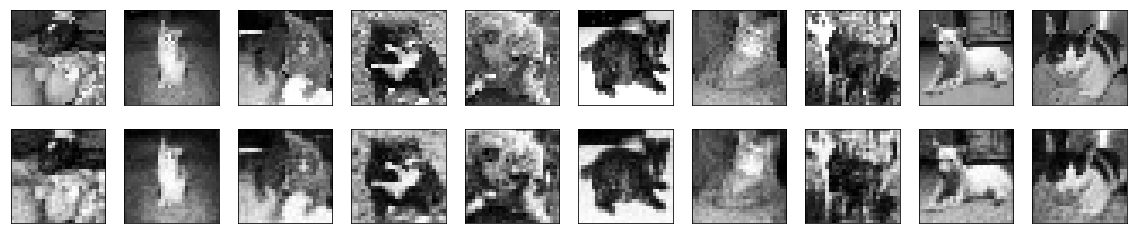

In [235]:
decoded_imgs = autoencoder.predict(cat_test)

n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cat_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Fully connected hidden layers in the autoencoder

* It seems like the more layers you have, the more training data you need (because the weights update slower). I think. 
* Because doing something like Input-600-400 for the encoder is not converging as quickly as the single complete layer. 

In [414]:
# size of our encoded representation (aka latent space, aka compression)
encoding_dim = 64 # 32 floats

# building the network
input_img = Input(shape=(784,))
encoded = Dense(700, activation='relu')(input_img)
encoded = Dense(600, activation='relu')(encoded)

decoded = Dense(600, activation='relu')(encoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [415]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_78 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 700)               549500    
_________________________________________________________________
dense_3 (Dense)              (None, 600)               420600    
_________________________________________________________________
dense_4 (Dense)              (None, 600)               360600    
_________________________________________________________________
dense_5 (Dense)              (None, 784)               471184    
Total params: 1,801,884
Trainable params: 1,801,884
Non-trainable params: 0
_________________________________________________________________


In [301]:
autoencoder.fit(cat_train, cat_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                )

Epoch 1/100
12500/12500 [==============================] - 3s - loss: 0.6512     
Epoch 2/100
12500/12500 [==============================] - 2s - loss: 0.6159     
Epoch 3/100
12500/12500 [==============================] - 2s - loss: 0.6063     
Epoch 4/100
12500/12500 [==============================] - 2s - loss: 0.6034     
Epoch 5/100
12500/12500 [==============================] - 2s - loss: 0.5934     
Epoch 6/100
12500/12500 [==============================] - 2s - loss: 0.5895     
Epoch 7/100
12500/12500 [==============================] - 2s - loss: 0.5857     
Epoch 8/100
12500/12500 [==============================] - 2s - loss: 0.5869     
Epoch 9/100
12500/12500 [==============================] - 2s - loss: 0.5817     
Epoch 10/100
12500/12500 [==============================] - 2s - loss: 0.5794     
Epoch 11/100
12500/12500 [==============================] - 2s - loss: 0.5780     
Epoch 12/100
12500/12500 [==============================] - 2s - loss: 0.5812     
Epoch 13/100


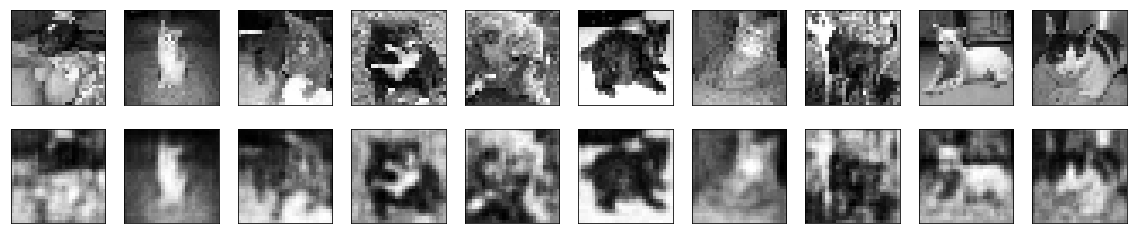

In [302]:
decoded_imgs = autoencoder.predict(cat_test)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cat_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Summary
So yeah.
Not great.
Fully Connected not really great in reconstructing. It's decent, I guess. 

## Denoising autoencoder

* Let's try to make it better
* We're going to add Gaussian noise to the training input, and fit the model to the original images. This should add some regularization: force the model to fit the relationships between the pixels, rather than simple memorization.

In [389]:
def is_cat(image_name):
    try:
        word_label = image_name.split('.')[-3]
    except IndexError:
        print(image_name)
    return word_label == 'cat'

def get_cat_noisy_training_data(file, refresh=False):
    p = os.path.join(os.getcwd(), file)
    if (not refresh and os.path.isfile(p)):
        cat_train_noisy = np.load(file)
        print(cat_train_noisy.shape)
        return cat_train_noisy
    else:     
        i = 0
        cat_train_noisy = []
        for img in os.listdir(TRAIN_DIR):
            if is_cat(img):
                path = os.path.join(TRAIN_DIR, img)
                img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
                img_data = img_data.astype('float32') / 255.
                
                noise_factor = 0.1
                img_data = img_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img_data.shape) 
                img_data = np.clip(img_data, 0., 1.)
                img_data = np.array(img_data).flatten()
                cat_train_noisy.append(img_data)
        cat_train_noisy = np.array(cat_train_noisy)
        np.save(file, cat_train_noisy)
        print(cat_train_noisy.shape)
        return cat_train_noisy
     
    
cat_train_noisy = get_cat_noisy_training_data('cat_train_noisy.npy', False)

(12500, 784)


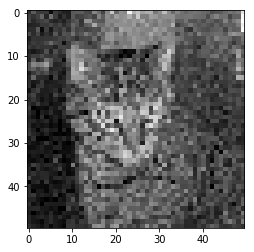

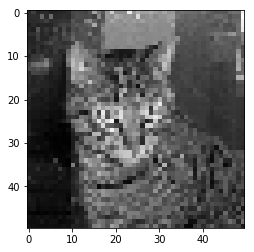

In [150]:
# Verify that noising happened

plt.imshow(cat_train_noisy[1].reshape(IMG_SIZE, IMG_SIZE))
plt.show()

plt.imshow(cat_train[1].reshape(IMG_SIZE, IMG_SIZE))
plt.show()


In [392]:
# size of our encoded representation (aka latent space, aka compression)
encoding_dim = 64 # 32 floats

# building the network
input_img = Input(shape=(784,))
encoded = Dense(700, activation='relu')(input_img)
encoded = Dense(600, activation='relu')(encoded)

decoded = Dense(700, activation='relu')(encoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [394]:
autoencoder.fit(cat_train, cat_train_noisy,
                epochs=100,
                batch_size=256,
                shuffle=True,
                )

Epoch 1/100
12500/12500 [==============================] - 2s - loss: 0.5620     
Epoch 2/100
12500/12500 [==============================] - 2s - loss: 0.5619     
Epoch 3/100
12500/12500 [==============================] - 2s - loss: 0.5622     
Epoch 4/100
12500/12500 [==============================] - 2s - loss: 0.5624     
Epoch 5/100
12500/12500 [==============================] - 2s - loss: 0.5616     
Epoch 6/100
12500/12500 [==============================] - 2s - loss: 0.5618     
Epoch 7/100
12500/12500 [==============================] - 2s - loss: 0.5619     
Epoch 8/100
12500/12500 [==============================] - 2s - loss: 0.5619     
Epoch 9/100
12500/12500 [==============================] - 2s - loss: 0.5618     
Epoch 10/100
12500/12500 [==============================] - 2s - loss: 0.5621     
Epoch 11/100
12500/12500 [==============================] - 2s - loss: 0.5615     
Epoch 12/100
12500/12500 [==============================] - 2s - loss: 0.5612     
Epoch 13/100


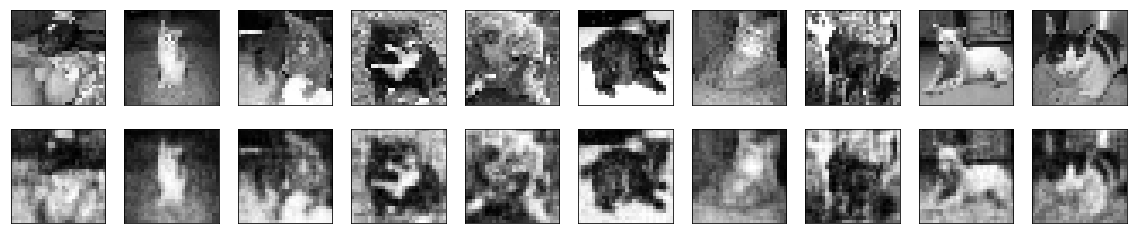

In [396]:
decoded_imgs = autoencoder.predict(cat_test)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cat_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Summary

* Okay so I think this fully-connected thing for images is not great. 
It's kind of bad at reconstructing the images, even when I do the encoder as Input (784)-700-600. 
Not great, even when I add Denoising. Denoising only seems to help a little bit?
The best loss I got was somewhere around the range 0.558. But the 0.54 range is when things actually start to approach a virtually perfect reconstruction.  

* I'm going to do Convolutional now because that seems much better. 
Denoising is probably also not that great when you do it on 28 x 28 images of varying intensity? Because the signal is a lot fuzzier than the MNIST Handwritten digits one. I think. 

## Convolutional Autoencoder

In [678]:
from keras.layers import Reshape
input_img = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
nRows = cat_train.shape[0]
cat_train = cat_train.reshape(nRows, IMG_SIZE, IMG_SIZE, 1)
cat_train_noisy = cat_train_noisy.reshape(nRows, IMG_SIZE, IMG_SIZE, 1)

# build the network
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2')(x)
x = MaxPooling2D((2, 2,), padding='same')(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same', name='conv3')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
decoded = Flatten()(encoded)
decoded = Dense(3072, activation="sigmoid")(decoded)
decoded = Reshape((IMG_SIZE, IMG_SIZE, 3))(decoded)

autoencoder.summary()




#x = Dense(784, activation="relu")(x)
#x = Reshape((7,7,16))(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

# x = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv4')(encoded)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv5')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv6')(x)
# x = UpSampling2D((2, 2))(x)
# decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='conv7')(x)


autoencoder = Model(input_img, decoded)
from keras.optimizers import Adam
autoencoder.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy')



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_153 (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_348 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_349 (MaxPoolin (None, 8, 8, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 8, 8, 100)         57700     
_________________________________________________________________
max_pooling2d_350 (MaxPoolin (None, 4, 4, 100)         0         
__________

In [741]:
nRows = x_train.shape[0]
x_train = x_train.reshape(nRows, IMG_SIZE, IMG_SIZE, 3)
nRows = x_test.shape[0]
x_test = x_test.reshape(nRows, IMG_SIZE, IMG_SIZE, 3)
nRows = cat_train_noisy.shape[0]
cat_train_noisy = cat_train_noisy.reshape(nRows, IMG_SIZE, IMG_SIZE, 1)

autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                )

Epoch 1/20
5000/5000 [==============================] - 11s - loss: 0.5329    
Epoch 2/20
5000/5000 [==============================] - 11s - loss: 0.5329    
Epoch 3/20
5000/5000 [==============================] - 11s - loss: 0.5327    
Epoch 4/20
5000/5000 [==============================] - 11s - loss: 0.5330    
Epoch 5/20
5000/5000 [==============================] - 11s - loss: 0.5326    
Epoch 6/20
5000/5000 [==============================] - 11s - loss: 0.5329    
Epoch 7/20
5000/5000 [==============================] - 11s - loss: 0.5326    
Epoch 8/20
5000/5000 [==============================] - 11s - loss: 0.5325    
Epoch 9/20
5000/5000 [==============================] - 11s - loss: 0.5328    
Epoch 10/20
5000/5000 [==============================] - 11s - loss: 0.5326    
Epoch 11/20
5000/5000 [==============================] - 11s - loss: 0.5325    
Epoch 12/20
5000/5000 [==============================] - 11s - loss: 0.5325    
Epoch 13/20
5000/5000 [==========================

In [744]:
autoencoder.save('really_good_color_car_conv')

In [115]:
nRows = cat_train.shape[0]
cat_train = cat_train.reshape(nRows, IMG_SIZE, IMG_SIZE, 1)


# I've already trained convolutional models for (16 and 8 filters) for 12 epochs. 
# It takes ~2 min to train. 
p = os.path.join(os.getcwd(), '2_layer_conv_autoencoder_50px_filters_6_3_epochs_12')
if (os.path.isfile(p)):
    autoencoder = load_model('2_layer_conv_autoencoder_50px_filters_6_3_epochs_12')
else:
    autoencoder.fit(cat_train, cat_train,
                epochs=12,
                batch_size=256,
                shuffle=True,
                )

In [742]:
cat_test = cat_test.reshape(cat_test.shape[0], IMG_SIZE, IMG_SIZE, 1)
decoded_imgs = autoencoder.predict(x_test)

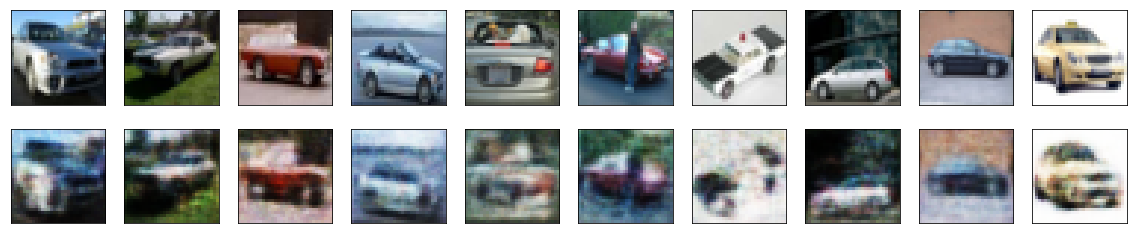

In [760]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    index = i + 180
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[index].reshape(IMG_SIZE, IMG_SIZE, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[index].reshape(IMG_SIZE, IMG_SIZE, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Summary

What, what!
I basically did one hidden layer with 16 convolutional filters (3, 3).
(each filter gives a feature activation map)

What!! And this thing only took like 2 min to train. 

* I initially used a lot of layers (Conv 16, Conv 8, Conv 8) with MaxPooling and UpSampling mixed in. But I got much faster convergence with a simpler model (one hidden layer Conv 16). 
* Sean made a good point: if you have multiple layers in your network, you're going to be optimizing a higher-dimensional loss function (since you have many more weights) --> more complex landscape. 
* Which is why large training datasets (or more training data) saves the day for large neural networks. 
* I'm pretty sure it's memorizing the input because it's reconstructing the test set as well as lamps and airplanes.

pass-through
increase filter size force transformation to be smaller
#### Question: I wonder what the feature activation maps are. Ask Evan how to visualize the layers of a conv net. 



  
What the actual fuck.   
The fully connected layers are giving better performance than the convolutional.   
* Are they like learning how to pass it through? Is that how they're doing it?   

Is this why everyone is doing MNIST?  
CIFAR-10 is 32x32. Maybe their images are better.  
Here's what I think:  
* 50 x 50 cat images are too complex. 
* In every image, the background makes up like half. 
* So the network, if it's learning to reconstruct it, it's fucking hard.
* Because the manifold is all over the place. There's cats with grey backgrounds, there's cats with rooms and the sky, there's cats held by human hands, etc. 
* I could try morphing the cat training images, and adding that to the training set. 
* I could try reducing to 32 x 32 images. 
* I could try reducing the number of images. 
* I could do it on MNIST images, and visualize everything. 
* Start small. Start from step 1, where everyone is starting. 
* Shit I mean I was using the same convolutional architecture they were using for MNIST images. I mean granted, I increased the pixel size and did it on much more complex images, but still. 
* Maybe do something really simple. Like the cars from CIFAR-10 first. That seems simple. 


## Now that it's trained on cats, test on other categories. 

### Airplanes, Buddha, Lamp, Faces, Cup

(10, 50, 50, 1)


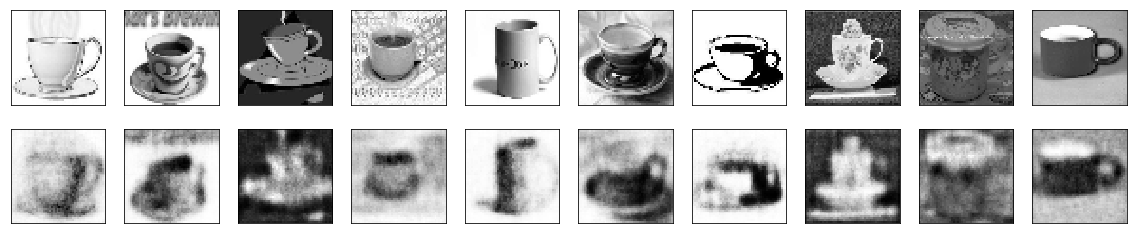

In [477]:
test = get_testing_data_by_category('cup')

test = test.reshape(test.shape[0], IMG_SIZE, IMG_SIZE, 1)
print(test.shape)
decoded_imgs = autoencoder.predict(test)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test[i].reshape(IMG_SIZE, IMG_SIZE))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(IMG_SIZE, IMG_SIZE))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Summary
Man this is doing really well classifying all sorts of things perfectly. 
I've definitely got to look at visualizing what each convolution filter is doing because I don't get it. 
**How is it so good?** It trains on cats, and it perfectly reconstructs chairs, faces, and ceiling fans. 

* Lmao it's almost certainly just passing the input image through. 
* If the output of the conv layer is 47 x 47 (since you feed it 50 x 50), it's so easy for it to just map pixels to pixels and pass the value through. You're not bottling anything. 
* I don't know whether it's memorizing the input. I mean, I added denoising so it shouldn't be memorizing the input. 
* I don't know whether adding more convolutional layers will help it only do cat features. I changed from 1 layer to 2 layers and it got even better. 


## CIFAR-10/MNIST Data (not sure about this)

In [23]:
(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [512]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

[6]
(5000, 32, 32, 3)


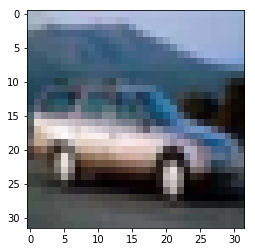

In [726]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
not_cars = np.where(y_train!=1)[0]
boom = np.copy(x_train)
x_train = np.delete(x_train, not_cars, axis=0)
x_train = x_train.astype('float32') / 255.
not_cars = np.where(y_test!=1)[0]
x_test = np.delete(x_test, not_cars, axis=0)
x_test = x_test.astype('float32') / 255.

not_birds = np.where(y_train!=2)[0]
birds = np.delete(boom, not_birds, axis=0)
birds = birds.astype('float32') / 255.
print(y_train[0])
print(x_train.shape)
plt.imshow(x_train[0])
plt.show()

In [527]:
i = np.array([0, 2])
boom = np.array([[1, 2, 2], [11111, 12, 12], [11, 12, 12]])
np.delete(boom, i, axis=0)

array([[11111,    12,    12]])

In [530]:
np.where(y_train!=1)[0]

array([    0,     1,     2, ..., 49995, 49996, 49997])

In [24]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s - loss: 0.3827 - val_loss: 0.2728
Epoch 2/50
60000/60000 [==============================] - 1s - loss: 0.2656 - val_loss: 0.2552
Epoch 3/50
60000/60000 [==============================] - 1s - loss: 0.2450 - val_loss: 0.2325
Epoch 4/50
60000/60000 [==============================] - 1s - loss: 0.2242 - val_loss: 0.2138
Epoch 5/50
60000/60000 [==============================] - 1s - loss: 0.2085 - val_loss: 0.2006
Epoch 6/50
60000/60000 [==============================] - 2s - loss: 0.1973 - val_loss: 0.1911
Epoch 7/50
60000/60000 [==============================] - 2s - loss: 0.1888 - val_loss: 0.1837
Epoch 8/50
60000/60000 [==============================] - 2s - loss: 0.1819 - val_loss: 0.1773
Epoch 9/50
60000/60000 [==============================] - 2s - loss: 0.1760 - val_loss: 0.1719
Epoch 10/50
60000/60000 [==============================] - 2s - loss: 0.1709 - val_loss: 0.1670

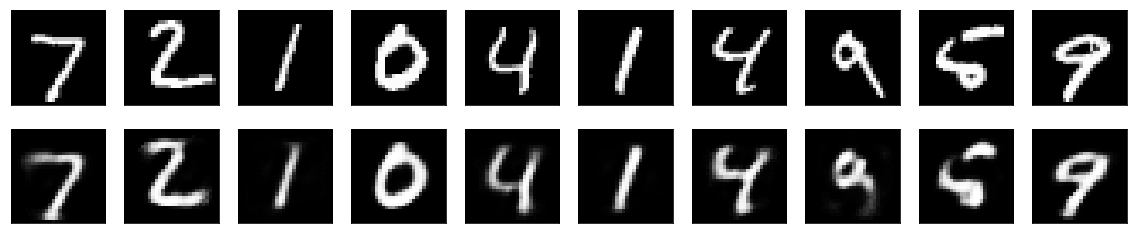

In [19]:
decoded_imgs = autoencoder.predict(x_test)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()